In [1]:
# Vectors, matrices, data manipulation, tables and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# Statistics, econometrics
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
# Function minimization for dates
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
# Nice progressbar and ..
from itertools import product
from tqdm import tqdm_notebook as tqdm
# Show plots inline
%matplotlib inline

Load dataset

In [28]:
ads = pd.read_csv('data/ads.csv')


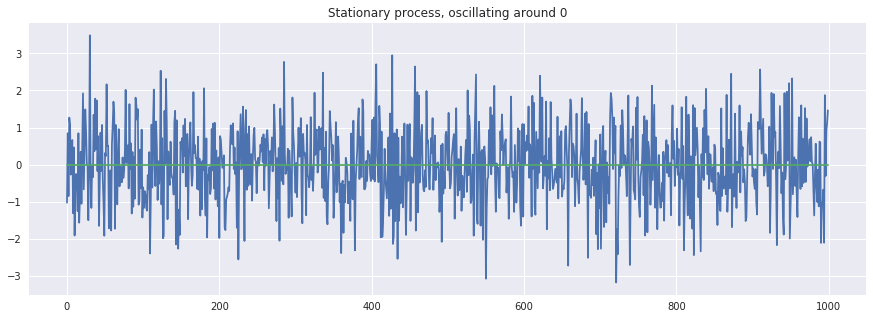

In [18]:
# Random time series
white_noise = np.random.normal(size=1000)
# Plot white noise
with plt.style.context('seaborn'):
    plt.figure(figsize=(15, 5))
    plt.title("Stationary process, oscillating around 0 with deviation of 1")
    plt.plot(white_noise)
    plt.plot(range(len(white_noise)),[0] * len(white_noise))


Now generate a new one with each subsequent value depending on the previous: $x_{t} = \rho x_{t-1} + e_{t}$

In [29]:
def plot_process(samples=1000, rho=0):
    """
    Arguments:
    ------------------------------------
        samples : int
                Number of points to plot
        rho     : float or int
                Dickey-Fuller rho-value           
    """
    # Define random points of count samples and of normal distribution
    x = w = np.random.normal(size=samples)
    # Create dependency on the previous subsequent value
    for t in range(samples):
        x[t] = rho * x[t-1] + w[t]
    # Plot
    with plt.style.context('seaborn'):
        plt.figure(figsize=(15,7), facecolor='#89a1c3')
        plt.plot(x)
        plt.title(f'Rho:{rho}'+'\n'+f'Dickey-Fuller p-value: {round(sm.tsa.stattools.adfuller(x)[1], 3)}')
        
    
        

#### Dickey-Fuller stationarity test:
 If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1

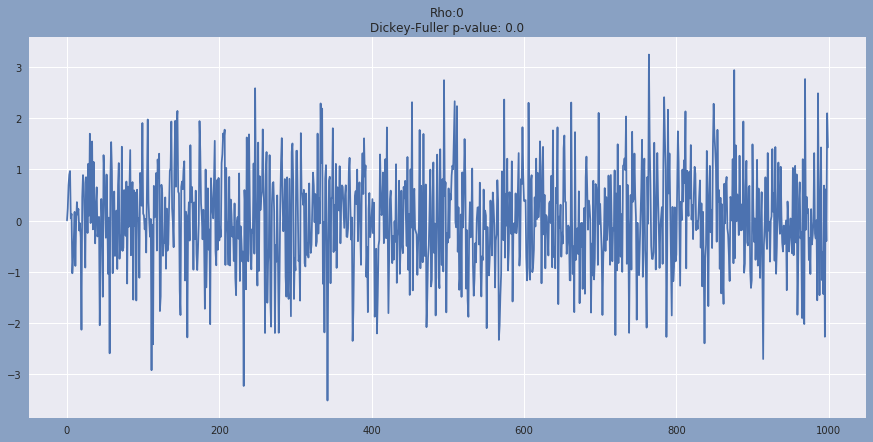

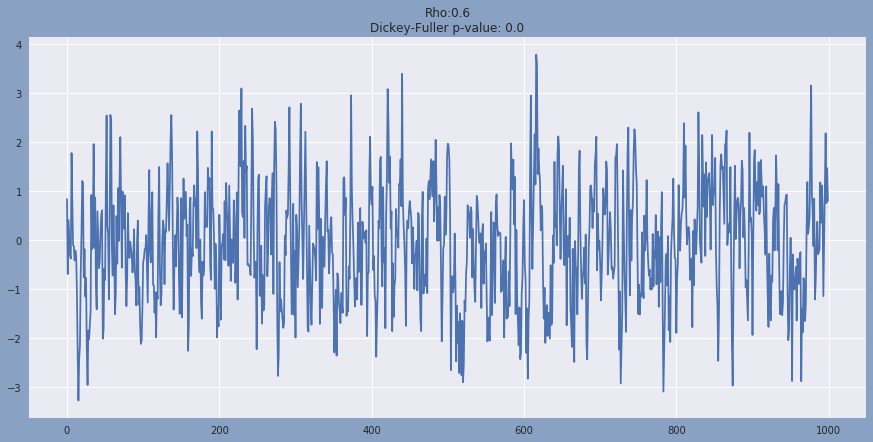

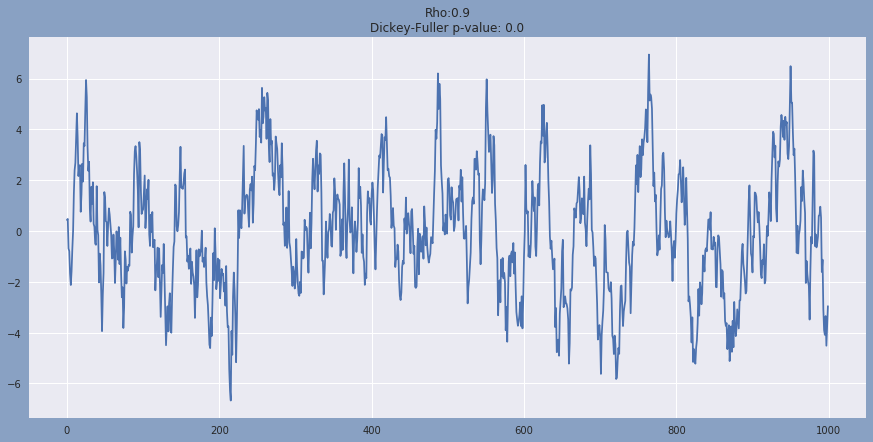

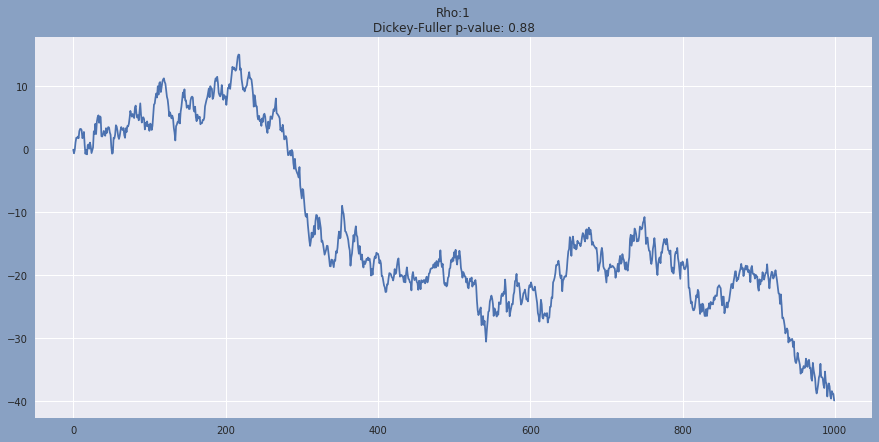

In [23]:
for rho in [0, 0.6, 0.9, 1]:
    plot_process(rho=rho)

Approaches to get rid of non-stationarity:
* various order differences
* trend removal
* seasonality removal
* smoothing 
* transformations (for example logarithmic or exponential)

## Make time-series stationary and build SARIMA

In [31]:
def tsplot(series, lags=None, figsize=(12,10), style='seaborn'):
    # forcely convert series to pandas.Series
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    # Use style pattern
    with plt.style.context(style):
        # Create a figure of figsize
        plt.figure(figsize=figsize, facecolor='#f9c8da')
        layout = (2,2)
        # Create subplots
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        # Plot the first plot
        series.plot(ax=ts_ax)
        # Calculate the p-value
        p_value = sm.tsa.stattools.adfuller(series)[1]
        # Set title
        ts_ax.set_title("Time Series analysis Plots \n Dickey-Fuller: {0:.5f}".format(p_value))
        
        # Plot the second and third plot
        smt.graphics.plot_acf(series,lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(series, lags=lags, ax=pacf_ax)
        
        plt.tight_layout()
    

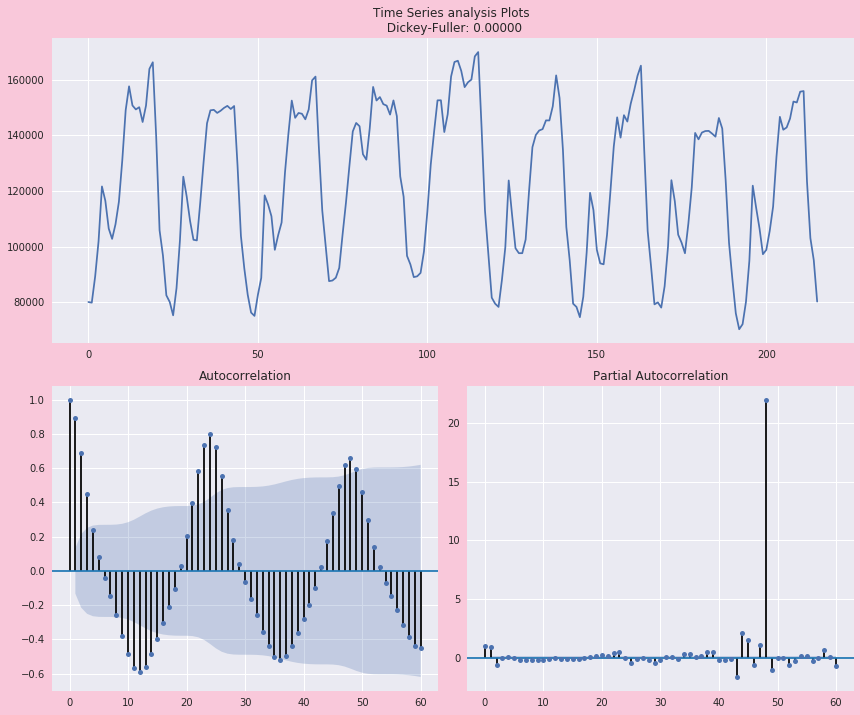

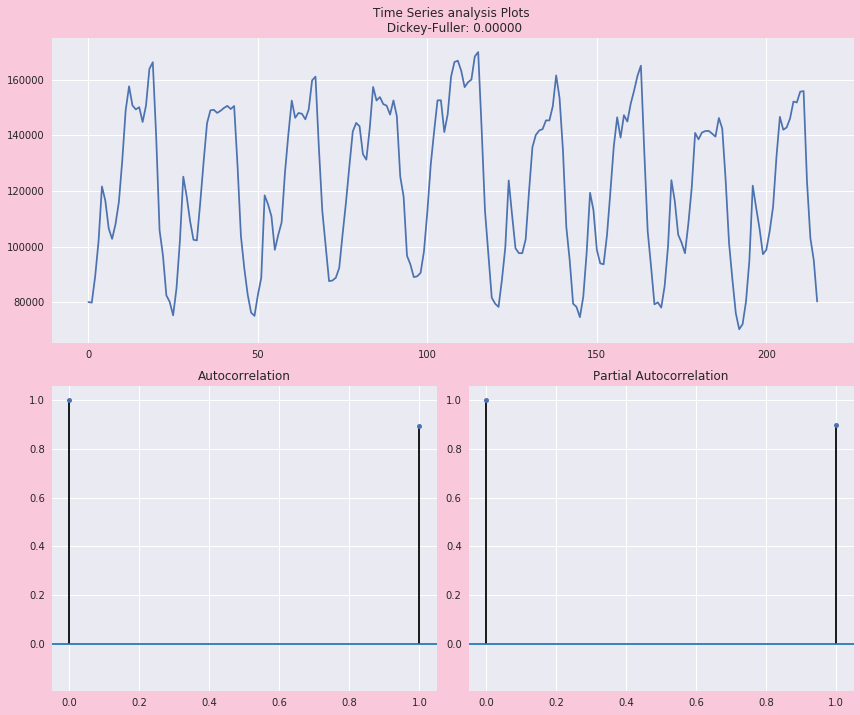

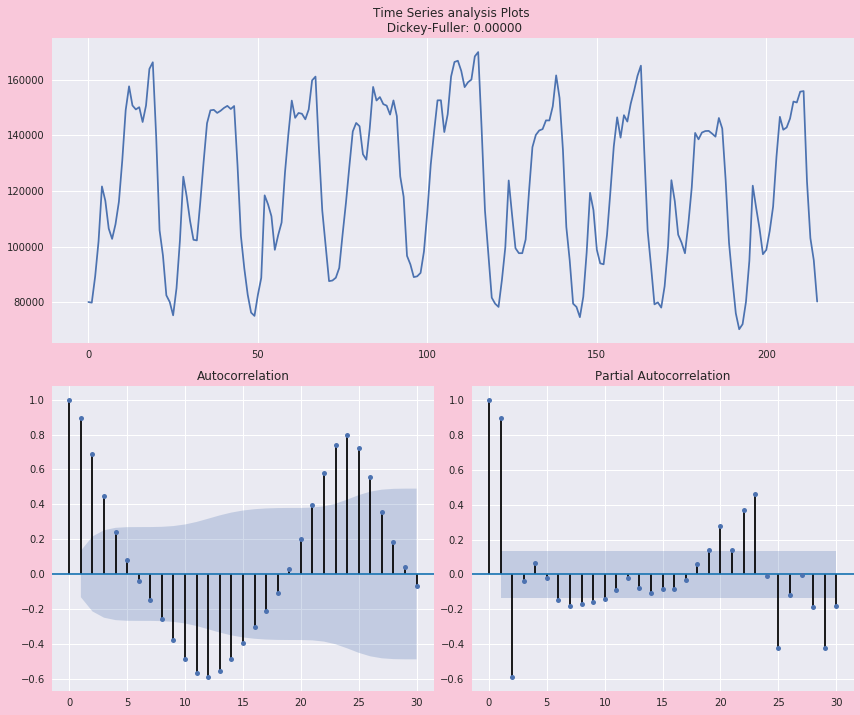

In [33]:
tsplot(ads.Ads, lags=60)
tsplot(ads.Ads, lags=1)
tsplot(ads.Ads, lags=30)
